In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.decomposition import PCA
import timeit
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from sklearn.datasets import load_boston
boston  = load_boston()
boston.feature_names
data=pd.DataFrame(boston.data,columns=boston.feature_names)
y=pd.DataFrame(boston.target,columns=['target'])
data.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [3]:
# Предпроцессинг
scaler_y = StandardScaler()
scaler_y.fit(y)
y = scaler_y.transform(y)
y = pd.DataFrame(y, columns=['target'])

X=data[:]
columns4normolize=X[:]
columns4normolize.drop(['CHAS','ZN','RAD'], axis=1, inplace=True)
scaler_X = StandardScaler()
scaler_X.fit(columns4normolize)
X_scaled = scaler_X.transform(columns4normolize)
X_scaled = pd.DataFrame(X_scaled, columns=columns4normolize.columns)
for col in columns4normolize.columns:
    X[col]=X_scaled[col]
X = pd.get_dummies(X, columns=['ZN', 'RAD'])
# Деление на тестовую и обучающую выборки
# Начиная осюда будем брать за основу для подбора параметров и оптимизации ix_trn
# ix_tst отложим до самого конца, когда будут произведены все настройки моделей и можно будет провести итоговое сравнение
sss = ShuffleSplit(n_splits=1, test_size=0.1)
sss.get_n_splits(X, y)
trn_ix, tst_ix = next(sss.split(X, y)) 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [4]:
# Функция оценки качества построения линейной регрессии для разбиении на k главных компанент.
def calc_rezult(X,y,trn_ix,tst_ix,k):
    pca=PCA(n_components=k)
    X2 = pca.fit_transform(X)
    model = linear_model.LinearRegression()
    model.fit( X2[trn_ix], y.values[trn_ix] )
    y_pred = model.predict(X2[tst_ix])
    mse=(np.square(y.values[tst_ix] - y_pred)).mean()
    corr=np.corrcoef(y.values[tst_ix].transpose().tolist()[0],y_pred.transpose().tolist()[0])[0][1]
    return [mse,corr]

MSE


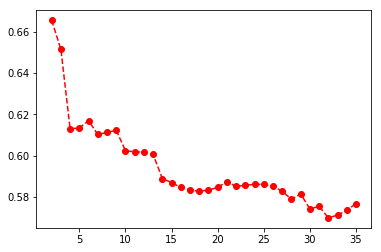

correlation


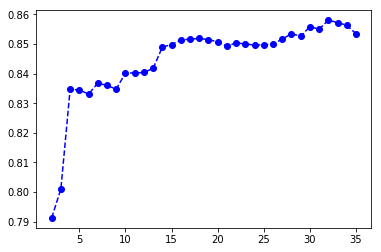

time


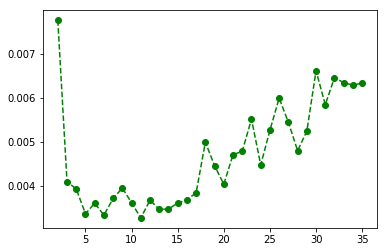

In [5]:
# Так как количиство фичей большое (~40) проведем простой анализ МГК
n_kfold=9
kf = KFold(n_splits=n_kfold, random_state=5, shuffle=True)
x_exp=np.arange(2,int(X.shape[1])-10,1);
y_exp=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
stop = timeit.default_timer()
k=0;
for i in x_exp:
    j=0;
    buf1=np.zeros(n_kfold)
    buf2=np.zeros(n_kfold)
    buf3=np.zeros(n_kfold)
    for trn_ix2, tst_ix2 in kf.split(X.values[trn_ix],y.values[trn_ix]):
        start = timeit.default_timer()
        buf1[j], buf2[j]=calc_rezult(X,y,trn_ix2,tst_ix2,i)
        stop = timeit.default_timer()
        buf3[j]=stop-start
        j=j+1
    y_exp[0][k]=np.exp(np.log10(buf1).mean())
    y_exp[1][k]=buf2.mean()
    y_exp[2][k]=buf3.mean()
    k=k+1;
plt.plot(x_exp,y_exp[0],'ro--')
print('MSE')
plt.show()
plt.plot(x_exp,y_exp[1],'bo--')
print('correlation')
plt.show()
plt.plot(x_exp,y_exp[2],'go--')
print('time')
plt.show()

#### Оптимальное количесто ГК - 14.

In [6]:
pca=PCA(n_components=14)
X_pca = pca.fit_transform(X)
y=y.values

In [7]:
def method_LR(X,y,trn_ix,tst_ix,n):
    poly = PolynomialFeatures(degree=n)
    X_ = poly.fit_transform(X[trn_ix])
    X_pred_ = poly.fit_transform(X[tst_ix])
    clf = linear_model.LinearRegression()
    result=clf.fit(X_, y[trn_ix])
    corr=np.corrcoef(y[tst_ix].transpose().tolist()[0],clf.predict(X_pred_).transpose().tolist()[0])[0][1]
    mse=(np.square(y[tst_ix] - clf.predict(X_pred_))).mean()
    return [mse,corr]   

MSE


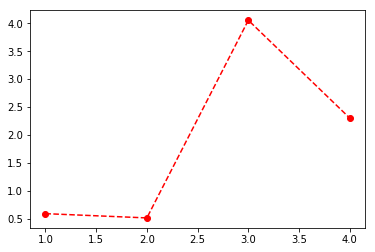

correlation


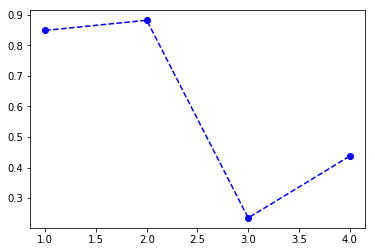

time


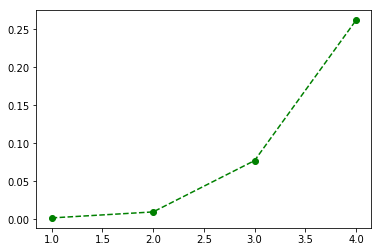

In [8]:
# Произведем анализ влияния степени полинома на качество зависимости
n_kfold=9
kf = KFold(n_splits=n_kfold, random_state=5, shuffle=True)
x_exp=np.arange(1,5,1)
y_exp=np.array([np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0]),np.zeros(x_exp.shape[0])])
k=0
for i in x_exp:
    buf1=np.zeros(n_kfold)
    buf2=np.zeros(n_kfold)
    buf3=np.zeros(n_kfold)
    j=0
    for trn_ix2, tst_ix2 in kf.split(X_pca[trn_ix],y[trn_ix]):
        start = timeit.default_timer()
        buf1[j], buf2[j]=method_LR(X_pca,y,trn_ix2,tst_ix2,i)
        stop = timeit.default_timer()
        buf3[j]=stop-start
        j=j+1
    y_exp[0][k]=np.exp(np.log10(buf1).mean())
    y_exp[1][k]=buf2.mean()
    y_exp[2][k]=buf3.mean()
    k=k+1;
plt.plot(x_exp,y_exp[0],'ro--')
print('MSE')
plt.show()
plt.plot(x_exp,y_exp[1],'bo--')
print('correlation')
plt.show()
plt.plot(x_exp,y_exp[2],'go--')
print('time')
plt.show()

### Итого лучший результат достигается при n = 2 (степень полинома)

In [9]:
param_dist=dict(alpha=list(( np.arange(0.1,1.01,0.01) )**10))
lr_model = linear_model.Lasso()
rr_model=linear_model.Ridge()

In [10]:
lr_best=RandomizedSearchCV(lr_model, param_dist,cv=9,scoring='neg_median_absolute_error',n_iter=11,n_jobs=4)
lr_best.fit(X_pca[trn_ix],y[trn_ix])
print('Score: ' + str(lr_best.best_score_))
print(lr_best.best_params_)

Score: -0.24393502066020942
{'alpha': 0.003620333314568895}


In [11]:
rr_best=RandomizedSearchCV(rr_model, param_dist,cv=9,scoring='neg_median_absolute_error',n_iter=11,n_jobs=4)
rr_best.fit(X_pca[trn_ix],y[trn_ix])
print('Score: ' + str(rr_best.best_score_))
print(rr_best.best_params_)

Score: -0.24558366236057305
{'alpha': 9.536743164062468e-07}


In [12]:
def LassoOrRidgeRegression(X, y, trn_ix,tst_ix, model_alpha,v):
    if v<1:
        clf = linear_model.Lasso(model_alpha)
        clf.fit(X[trn_ix], y[trn_ix])
        y_pred = clf.predict(X[tst_ix])
    else:
        clf = linear_model.Ridge(model_alpha)
        clf.fit(X[trn_ix], y[trn_ix])
        y_pred = clf.predict(X[tst_ix]).transpose()[0]
    y_tst = y[tst_ix].transpose()[0]
    mse=(np.square(y_tst - y_pred)).mean()
    corr=np.corrcoef(y_pred,y_tst)[0][1]
    return [mse,corr]

In [13]:
time0 = timeit.default_timer()
mse_lp,corr_lp = method_LR(X_pca,y,trn_ix,tst_ix,2)
time1 = timeit.default_timer()
mse_lp,corr_lp = method_LR(X_pca,y,trn_ix,tst_ix,2)
time2 = timeit.default_timer()
mse_lr,corr_lr = LassoOrRidgeRegression(X_pca,y,trn_ix,tst_ix, lr_best.best_params_['alpha'],0)
time3 = timeit.default_timer()
mse_rr,corr_rr = LassoOrRidgeRegression(X_pca,y,trn_ix,tst_ix, lr_best.best_params_['alpha'],1)
time4 = timeit.default_timer()
print('\t LinPolynom \t Lasso \t\t Ridge')
print('MSE: \t' + str(round(mse_lp,4)) + '\t\t' + str(round(mse_lr,4)) + '\t\t' + str(round(mse_rr,4)) )
print('Corr: \t' + str(round(corr_lp,4)) + '\t\t' + str(round(corr_lr,4)) + '\t\t' + str(round(corr_rr,4)) )
print('time: \t' + str(round(time2-time1,6)) + '\t' + str(round(time3-time2,6)) + '\t' + str(round(time4-time3,6)) )

	 LinPolynom 	 Lasso 		 Ridge
MSE: 	0.1187		0.5473		0.5397
Corr: 	0.9382		0.6712		0.6787
time: 	0.018335	0.001373	0.001464


### В итогу лучшим методом регрессии становится полиномиальная (степени 2)

Я планирую выполнить домашние задания "Ансамблированию" и "Функциям потерь и оптимизации" в срок до 27.12.18. Так как официальный срок сдачи уже истек и я не могу разместить ссылку на сайте нетология, я буду скидывать ссылки на питхаб Вам в Слак. Прошу Вас проверить и поставить мне зачет по итогам на сайте "нетологии". Спасибо.